In [204]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import cleaning_script
import missingno as msno
import re

In [205]:
# import data
house_train = pd.read_csv('datasets/train.csv')
house_train.head(1)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500


In [206]:
house_train['meltdown'] = [1 if sale_year > 2006 else 0 for sale_year in house_train['Yr Sold']]

In [207]:
# property size, location, desirability, nearby amenities, number of rooms, construction materials, age/condition of structure.
# house_train.columns = ['_'.join(re.findall('[A-Z][a-z]*', x)) for x in house_train.columns]
# house_train.columns = [col.lower() for col in house_train.columns]

# msno.matrix(house_train[['Lot Shape', 'Utilities', 'Lot Config']])

<AxesSubplot:ylabel='Frequency'>

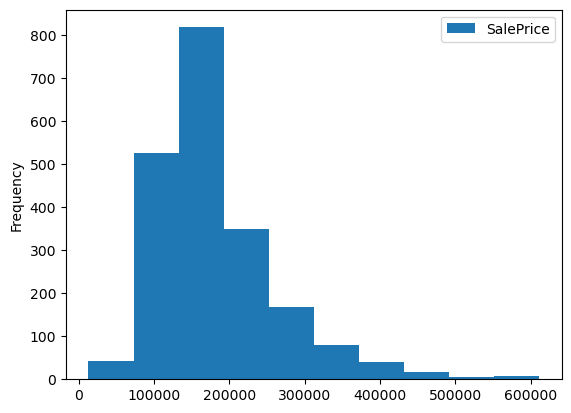

In [208]:
house_train.plot.hist(y = 'SalePrice')

<AxesSubplot:xlabel='SalePrice', ylabel='Gr Liv Area'>

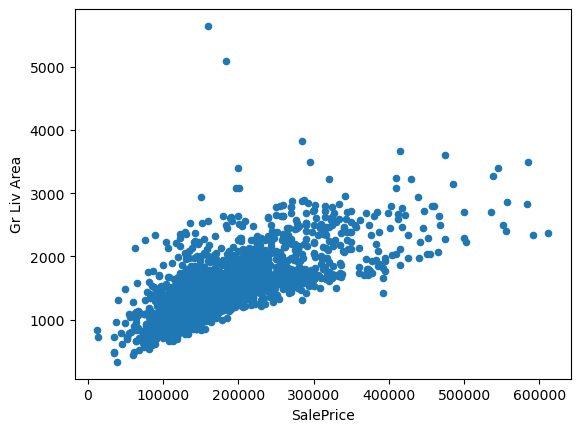

In [209]:
house_train.plot.scatter(x='SalePrice', y = 'Gr Liv Area')

# Age

In [210]:
house_train['age'] = house_train['Yr Sold'] - house_train['Year Built']

# Neighborhood Group

In [211]:
test = house_train.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False)

neighbor_hood_dict = {}
for i, val in enumerate(test):
    neighbor_hood_dict.update({test.index[i]:i})

house_train['neighborhood_price_rank'] = [neighbor_hood_dict[neighborhood] for neighborhood in house_train.Neighborhood]

In [212]:
# house_train = house_train[~cleaning_script.is_outlier(house_train['Gr Liv Area'])]
# house_train = house_train[~cleaning_script.is_outlier(house_train['SalePrice'])]

In [213]:
house_train.shape

(2051, 84)

# Quick Model

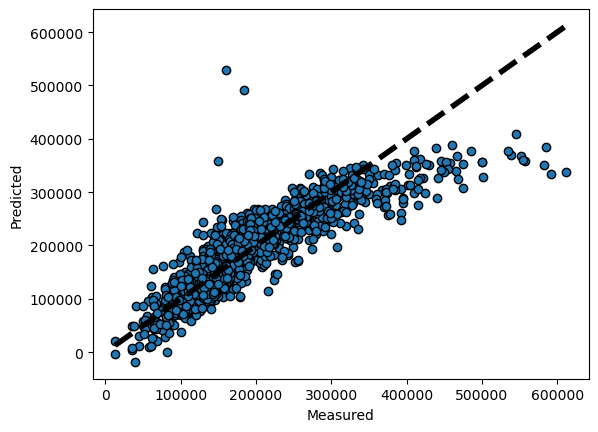

Accuracy: 0.78 ± 0.07


In [214]:
X = house_train[['neighborhood_price_rank', 'Gr Liv Area', 'Overall Qual', 'age', 'Full Bath', 'meltdown']]
y = house_train.SalePrice
# scores are r^2
scores_1 = (cross_val_score(LinearRegression(), X, y, cv = KFold(n_splits=5,
                                                                 shuffle=True,
                                                                 random_state=73)))

y_pred = (cross_val_predict(LinearRegression(), X, y,cv = KFold(n_splits=5,
                                                                 shuffle=True,
                                                                 random_state=73)))


fig, ax = plt.subplots()
ax.scatter(house_train.SalePrice, y_pred, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()
print("Accuracy: %0.2f ± %0.2f" % (scores_1.mean(), scores_1.std() * 2))

In [215]:
house_train['Yr Sold'].unique()

array([2010, 2009, 2006, 2007, 2008], dtype=int64)